<a href="https://colab.research.google.com/github/Geometallurgy/LCT_notebooks/blob/main/geomet_salobo_icj_ufmg_Exp_Log_Reg_backup2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
# <font size = 12 color = royalblue> INTRODUÇÃO </font>
***

Modelagem Geometalúrgica - Estudo de Caso da Mina de Cobre do Salobo (Vale) - Exponential regression/Logarithmic regression

**Autor(a):**

João Vitor Figueiredo Guerra


**Orientador:** Douglas B. Mazzinghy

Instituição: Departamento de Engenharia de Minas da UFMG


##  BIBLIOTECAS

In [1]:
import numpy as np # Biblioteca para operações matemáticas eficientes com arrays
import pandas as pd # Importação e manipulação de dados em DataFrames
import matplotlib.pyplot as plt # Criação de gráficos estáticos

#------------ basicos ---------------------
import itertools
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import math
import seaborn as sns # Criação de gráficos estatísticos mais avançados
# Statsmodels: a biblioteca principal para modelagem e análise estatística
import statsmodels.api as sm
# Módulos específicos do Statsmodels para testes estatísticos e diagnósticos
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.graphics.gofplots import qqplot # Para Q-Q plot dos resíduos
from statsmodels.graphics.tsaplots import plot_acf # Para plot de autocorrelação dos resíduos
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt,het_white
from statsmodels.stats.diagnostic import linear_harvey_collier, linear_reset, spec_white
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

from sklearn.utils import resample

from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor

# Biblioteca para suprimir avisos de código
import warnings
warnings.filterwarnings("ignore")


***
# <font size = 12 color = green> CONHECENDO DADOS </font>
***


## [1] BAIXANDO DATASET

O dataset flotation.csv é um conjunto de dados geometalúrgicos voltado para a flotação. Ele contém dados de diversas amostras de minério , e as respectivas medições de variáveis(teores) que influenciam o processo de tratamento do minério bruto.

In [2]:
url1 = 'https://zenodo.org/records/7051975/files/comminution.csv?download=1' #link do dataset utilizado;

df_comminution = pd.read_csv(url1) # df é nome do dataframe que vai carregar os dados iniciais das amostras e o resultado do calculo do Bond Work Index (BWI) - *Não utilizado nesse notebook*.

s = 'https://zenodo.org/record/7051975/files/flotation.csv?download=1' #link do dataset utilizado;

df_flotation = pd.read_csv(s) # df é nome do dataframe que vai carregar os dados iniciais das amostras e o resultado do calculo de Recuperação Metalúrgica (LCT).

url3 = 'https://zenodo.org/record/7051975/files/drillholes.csv?download=1'  #link do dataset utilizado;

df_drillholes = pd.read_csv(url3) # df é nome do dataframe que vai carregar os dados dos furos. - *Não utilizado nos calculos desse notebook*

##[3] VISUALIZAÇÃO DOS DADOS

In [3]:
#Mostra amostras de dados presentes em todos os datasets
print("\n=== COMMINUTION ===")
print(df_comminution.head())

print("\n=== FLOTATION ===")
print(df_flotation.head())

print("\n=== DRILLHOLES ===")
print(df_drillholes.head())


=== COMMINUTION ===
   HOLEID           X          Y       Z       th1       th2       th3  \
0     120  342.445175 -382.72032  337.81  0.042350  0.176221  0.402691   
1     121  127.095175  -88.51032  251.62  0.038470  0.191321  0.410466   
2     122  186.685175 -344.57032  334.54  0.030830  0.151751  0.326471   
3     123  297.195175 -219.90032  266.55  0.031255  0.196491  0.419411   
4     124  365.475175 -180.95032  264.01  0.038660  0.168131  0.382681   

           F80         P80         M  ...         Fe ppm         K ppm  \
0  2174.237514   97.105344  0.808429  ...  287065.387485  20113.863021   
1  2188.542916  115.508073  0.855116  ...  229643.336529  28938.287402   
2  1983.825716  102.098877  0.973609  ...  239465.402844  22656.358382   
3  1969.796571  116.762223  1.047199  ...  272844.696970  25535.603113   
4  2222.819841  100.826620  1.155266  ...  238553.639847  26901.626794   

        Mg ppm       Mn ppm       Na ppm       P ppm   S ppm         Si ppm  \
0  6621.98

In [4]:
# Criar o gráfico de dispersão 3D
fig = go.Figure()

# Adicionar amostras de furos de sondagem
fig.add_trace(go.Scatter3d(
    x=df_drillholes['X'],
    y=df_drillholes['Y'],
    z=df_drillholes['Z'],
    mode='markers',
    marker=dict(
        size=2,
        color='gray',
        opacity=0.8
    ),
    name='2000 drillholes samples',
    legendgrouptitle_text="Dataset Types",
    legendgroup="drillholes"
))

# Adicionar amostras de cominuição
fig.add_trace(go.Scatter3d(
    x=df_comminution['X'],
    y=df_comminution['Y'],
    z=df_comminution['Z'],
    mode='markers',
    marker=dict(
        size=2,
        color='magenta',
        opacity=0.8
    ),

    name='60 comminution samples',
    legendgroup="comminution"
))

# Adicionar amostras de flotação
fig.add_trace(go.Scatter3d(
    x=df_flotation['X'],
    y=df_flotation['Y'],
    z=df_flotation['Z'],
    mode='markers',
    marker=dict(
        size=2,
        color='cyan',
        opacity=0.8
    ),
    name='53 flotation samples',
    legendgroup="flotation"
))

# Atualizar layout para melhor visualização COM FUNDO BRANCO
fig.update_layout(
    paper_bgcolor='white',  # Fundo branco ao redor do gráfico
    plot_bgcolor='white',   # Fundo branco da área do gráfico

    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data',  # Garante a proporção correta para gráficos 3D

        # Configurações para fundo branco na cena 3D
        bgcolor='white',    # Fundo branco para a cena 3D

        # Opcional: personalizar as cores dos eixos para melhor contraste
        xaxis=dict(backgroundcolor="white", gridcolor="lightgray"),
        yaxis=dict(backgroundcolor="white", gridcolor="lightgray"),
        zaxis=dict(backgroundcolor="white", gridcolor="lightgray")
    ),

    title='Visualização 3D do Conjunto de Dados',
    showlegend=True,
    legend=dict(
        itemsizing='constant',  # Mantém o tamanho constante dos marcadores na legenda
        tracegroupgap=20,       # Aumenta o espaçamento entre os itens da legenda
        font=dict(size=12)      # Aumenta o tamanho da fonte da legenda
    )
)

# Personalizar a legenda para ter marcadores maiores
fig.update_traces(
    marker=dict(sizeref=0.1),  # Ajusta a escala dos marcadores na legenda
    selector=dict(mode='markers')
)

# Exibir o gráfico
fig.show()

In [5]:
coordinate_columns = ['X', 'Y', 'Z']
# Painel de estatísticas descritivas para cada teor do dataset flotation
fteor_columns = [col for col in df_flotation.columns if col not in coordinate_columns and df_flotation[col].dtype in ['int64', 'float64']]

print("\n" + "="*60)
print("ESTATÍSTICAS DESCRITIVAS DOS TEORES DA TABELA DE FLOTAÇÃO")
print("="*60)

for teor in fteor_columns:
    print(f"\n{teor}:")
    print(f"  Mínimo: {df_flotation[teor].min():.4f}")
    print(f"  Máximo: {df_flotation[teor].max():.4f}")
    print(f"  Média: {df_flotation[teor].mean():.4f}")
    print(f"  Mediana: {df_flotation[teor].median():.4f}")
    print(f"  Desvio Padrão: {df_flotation[teor].std():.4f}")


ESTATÍSTICAS DESCRITIVAS DOS TEORES DA TABELA DE FLOTAÇÃO

HOLEID:
  Mínimo: 1.0000
  Máximo: 133.0000
  Média: 31.0566
  Mediana: 15.0000
  Desvio Padrão: 32.4176

fr:
  Mínimo: 0.1644
  Máximo: 0.3830
  Média: 0.2480
  Mediana: 0.2352
  Desvio Padrão: 0.0510

xr:
  Mínimo: 0.0060
  Máximo: 0.0797
  Média: 0.0404
  Mediana: 0.0368
  Desvio Padrão: 0.0180

LCT:
  Mínimo: 0.7176
  Máximo: 0.9678
  Média: 0.8789
  Mediana: 0.8938
  Desvio Padrão: 0.0532

Ag ppm:
  Mínimo: 1.1630
  Máximo: 12.1011
  Média: 4.2273
  Mediana: 4.0725
  Desvio Padrão: 1.8502

Al ppm:
  Mínimo: 3932.1600
  Máximo: 65997.6041
  Média: 47728.3600
  Mediana: 50624.6305
  Desvio Padrão: 13968.3953

Au ppm:
  Mínimo: 0.0520
  Máximo: 4.5210
  Média: 0.7783
  Mediana: 0.4200
  Desvio Padrão: 0.9374

C ppm:
  Mínimo: 150.0000
  Máximo: 2865.0000
  Média: 721.3491
  Mediana: 607.0000
  Desvio Padrão: 524.3843

Ca ppm:
  Mínimo: 1068.9330
  Máximo: 39178.0056
  Média: 9810.1159
  Mediana: 6870.3700
  Desvio Padrão: 76

***
# <font size = 12 color = seablue> MODELOS PARA FLOTAÇÃO </font>
***

## [1] CORRELAÇÃO DE VARIAVÉIS DO DATASET DE FLOTAÇÃO



In [6]:
correlacao_lct = df_flotation.corr()["LCT"]

indices_ordenados_lct = correlacao_lct.abs().sort_values(ascending=False).index

correlacao_final_lct = correlacao_lct.loc[indices_ordenados_lct]
print(correlacao_final_lct)
#Para avaliar os dados a serem tratados  ao longo do processo foi feita uma matriz de correlação

LCT       1.000000
P ppm     0.384213
Na ppm    0.355076
U ppm     0.319124
HOLEID   -0.299982
Ca ppm    0.260416
X         0.255369
S ppm     0.253890
Y        -0.216998
Th ppm    0.194382
Fe ppm   -0.166833
Si ppm    0.142981
F ppm    -0.140369
Au ppm    0.136067
xr        0.125551
Mn ppm   -0.120639
Ag ppm   -0.107729
Cl ppm   -0.092207
K ppm     0.073175
Cu ppm    0.071574
fr       -0.063832
Al ppm    0.057436
Mg ppm    0.043904
Ti ppm    0.024532
Z        -0.015502
C ppm     0.007737
Name: LCT, dtype: float64


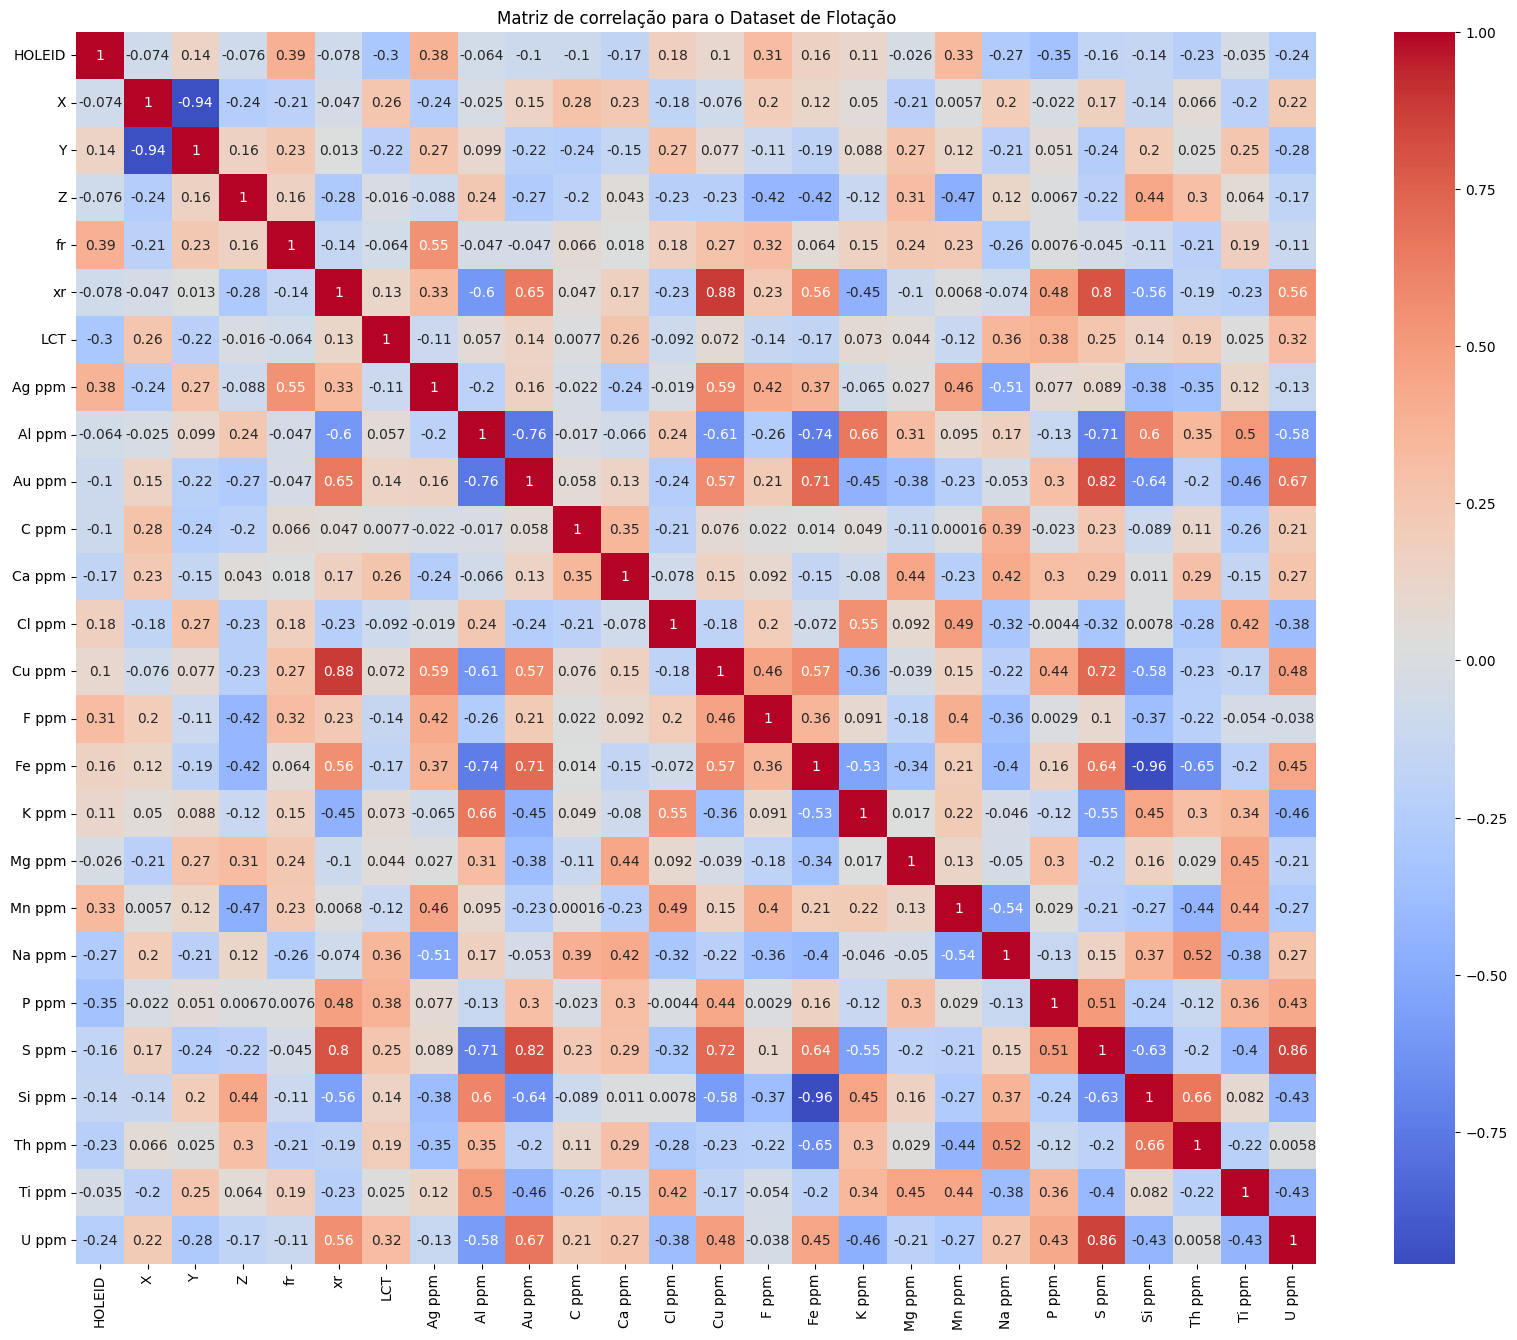

In [7]:
plt.figure(figsize=(20, 16))

sns.heatmap(df_flotation.corr(), annot=True, cmap="coolwarm")

plt.title('Matriz de correlação para o Dataset de Flotação')
plt.show()

## [2] PREPARAÇÃO PARA APLICAÇÃO DOS PRIMEIROS METODOS DE EXPONENCIAL/LOARITHMIC REGRESSION

In [8]:
df_temp_flotation = df_flotation.copy()

colunas_para_remover_flotation = ["HOLEID", "LCT", "fr", "xr", "X", "Y", "Z","Cl ppm"]
df_temp_flotation = df_temp_flotation.drop(columns=colunas_para_remover_flotation)

In [9]:
nan_index = df_temp_flotation[df_temp_flotation.isna()].index[0]

In [10]:


# Remova a linha correspondente
df_temp_flotation = df_temp_flotation.drop(nan_index)

print("NaNs  após remoção:", df_temp_flotation.isna().sum().sum())
print("Número de linhas:", len(df_temp_flotation))

NaNs  após remoção: 0
Número de linhas: 52


##[3] DEFINIÇÃO DAS FUNÇÕES DOS MODELOS

###STEPWISE

In [11]:

def stepwise_forward(X, y, criterion='aic'):


    included = []
    variables = list(X.columns)

    # score inicial = infinito
    best_score = np.inf

    while True:
        changed = False
        excluded = list(set(variables) - set(included))
        scores_with_candidates = []

        for new_var in excluded:
            # modelo teste: variáveis já incluídas + nova
            model_vars = included + [new_var]
            X_subset = X[model_vars].to_numpy()

            # adiciona intercepto
            X_design = np.column_stack((np.ones(X_subset.shape[0]), X_subset))

            # regressão linear
            beta = np.linalg.lstsq(X_design, y, rcond=None)[0]
            y_pred = X_design @ beta

            # métricas
            residual = y - y_pred
            rss = np.sum(residual**2)
            n, k = X_design.shape  # k já inclui intercepto

            # critérios
            if criterion == 'aic':
                score = n * np.log(rss/n) + 2 * k
            elif criterion == 'bic':
                score = n * np.log(rss/n) + np.log(n) * k
            else:
                raise ValueError("criterion deve ser 'aic' ou 'bic'")

            scores_with_candidates.append((score, new_var))

        # escolhe a melhor
        scores_with_candidates.sort()
        best_new_score, best_var = scores_with_candidates[0]

        # decide adicionar variável
        if best_new_score < best_score:
            included.append(best_var)
            best_score = best_new_score
            changed = True
        else:
            break

    return included


### EXPONENCIAL

In [12]:
from sklearn.preprocessing import PowerTransformer, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def exp_model(X, y, grau=0, show_plot=True):
    """
    grau 0 → sem transformação
    grau 1 → padronizado (StandardScaler)
    grau 2 → normalizado (Yeo-Johnson) + padronizado
    """

    X_oficial = X.copy()

    # Para salvar apenas se existirem
    yeo = None
    scaler = None


    # 1. Escolha da transformação


    if grau == 1 or grau == 2:

        # --- Normalização Yeo-Johnson ---
        if grau == 2:
            yeo = PowerTransformer(method='yeo-johnson')
            X_yeo_arr = yeo.fit_transform(X)
            X_temp = pd.DataFrame(X_yeo_arr, index=X.index, columns=X.columns)
        else:
            # grau 1 → não usa yeo
            X_temp = X.copy()

        # --- Padronização ---
        scaler = StandardScaler()
        X_scaled_arr = scaler.fit_transform(X_temp)
        X_oficial = pd.DataFrame(X_scaled_arr, index=X.index, columns=X.columns)

    # grau 0 → X_oficial permanece X original


    # 2. Linearização do modelo

    Y_log = np.log(y)

    # Stepwise
    selected_vars = stepwise_forward(X_oficial, Y_log)

    X_selected = X_oficial[selected_vars]

    # Remove colunas quase constantes
    X_filtered = X_selected.loc[:, X_selected.std() > 1e-6]


    # 3. Ajuste do modelo linear

    X_ones = np.column_stack((np.ones(X_filtered.shape[0]), X_filtered.values))
    coef = np.linalg.lstsq(X_ones, Y_log, rcond=1e-10)[0]

    a_est = np.exp(coef[0])
    b_est = coef[1:]

    # 4. Predição

    y_pred = a_est * np.exp(X_filtered.values @ b_est)


    # 5. Métricas

    n, k = X_filtered.shape
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)

    r2 = 1 - ss_res / ss_tot
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    rmse = np.sqrt(ss_res / n)
    aic = n * np.log(ss_res / n) + 2 * (k + 1)
    bic = n * np.log(ss_res / n) + np.log(n) * (k + 1)
    r2_adj_vals = []

   #erro padrão com bootstrap
    Xb_full = np.column_stack((np.ones(X_filtered.shape[0]), X_filtered.values))
    y_arr = y.values if hasattr(y, "values") else y

    for _ in range(500):  # 500 já fica ótimo; 1000 se quiser máxima precisão
        X_boot, y_boot = resample(Xb_full, y_arr)
        model_boot = sm.OLS(y_boot, X_boot).fit()
        r2_adj_vals.append(model_boot.rsquared_adj)

    r2_adj_se = np.std(r2_adj_vals)

    # 6. Equação formatada

    equacao = f"y = {a_est:.3e} * exp("
    for i, b in enumerate(b_est):
        sinal = " + " if b >= 0 else " - "
        equacao += f"{sinal}{abs(b):.2e}*({selected_vars[i]})"
    equacao += " )"


    # 7. Plot

    if show_plot:
        plt.figure(figsize=(6, 5))
        plt.scatter(y, y_pred, color="blue", label="Dados vs Modelo")
        plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label="Ideal (y = y_pred)")
        plt.xlabel("y real")
        plt.ylabel("y predito")
        plt.title("Comparação entre valores reais e modelo exponencial")
        plt.legend()
        plt.show()


    # 8. Retorno organizado

    results = {
        "grau": grau,
        "yeo_transformer": yeo,
        "scaler": scaler,
        "variaveis": selected_vars,
        "coef_intercepto": a_est,
        "coeficientes": dict(zip(selected_vars, b_est)),
        "equacao": equacao,
        "r2": r2,
        "r2_ajustado": r2_adj,
        "rmse": rmse,
        "r2_adj_se": r2_adj_se,
        "aic": aic,
        "bic": bic,
        "y_pred": y_pred
    }

    return results


###LOGARITIMICA

In [13]:
def log_model(X, y,grau=0, show_plot=True):

    # --- Linearização: aplica log nas variáveis X = processo contrario ao feito na exponenciação onde o log ia no y
    """
    grau 0 → sem transformação
    grau 1 → padronizado (StandardScaler)
    grau 2 → normalizado (Yeo-Johnson) + padronizado
    """

    X_oficial = X.copy()

    # Para salvar apenas se existirem
    yeo = None
    scaler = None


    # 1. Escolha da transformação


    if grau == 1 or grau == 2:

        # --- Normalização Yeo-Johnson ---
        if grau == 2:
            yeo = PowerTransformer(method='yeo-johnson')
            X_yeo_arr = yeo.fit_transform(X)
            X_temp = pd.DataFrame(X_yeo_arr, index=X.index, columns=X.columns)
        else:
            # grau 1 → não usa yeo
            X_temp = X.copy()

        # --- Padronização ---
        scaler = StandardScaler()
        X_scaled_arr = scaler.fit_transform(X_temp)
        X_oficial = pd.DataFrame(X_scaled_arr, index=X.index, columns=X.columns)

    # grau 0 → X_oficial permanece X original


    X_safe = X_oficial.copy()

    # Identifica negativos
    mask_neg = (X_safe < 0)
    n_neg = mask_neg.sum().sum()
    if n_neg > 0:
        print(f"Aviso: {n_neg} valores negativos detectados — convertendo para positivos.")
        X_safe[mask_neg] = np.abs(X_safe[mask_neg])

    # Aplica log normalmente
    X_log = np.log(X_safe)

    y = y.loc[X_log.index]


    selected_vars = stepwise_forward(X_log, y)
    X_selected = X_log[selected_vars]

    # --- Adiciona intercepto ---
    X_ones = np.column_stack((np.ones(X_selected.shape[0]), X_selected))
    coef = np.linalg.lstsq(X_ones, y, rcond=1e-10)[0]
    a_est = coef[0]
    b_est = coef[1:]

    # --- Predição ---
    y_pred = a_est + X_selected @ b_est

    # --- Métricas ---
    n, k = X_selected.shape
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res / ss_tot
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    rmse = np.sqrt(ss_res / n)
    aic = n * np.log(ss_res / n) + 2 * (k + 1)
    bic = n * np.log(ss_res / n) + np.log(n) * (k + 1)
    r2_adj_vals = []

    #erro padrão com bootstrap
    Xb_full = np.column_stack((np.ones(X_selected.shape[0]), X_selected.values))
    y_arr = y.values if hasattr(y, "values") else y

    for _ in range(500):  # 500 já fica ótimo; 1000 se quiser máxima precisão
        X_boot, y_boot = resample(Xb_full, y_arr)
        model_boot = sm.OLS(y_boot, X_boot).fit()
        r2_adj_vals.append(model_boot.rsquared_adj)

    r2_adj_se = np.std(r2_adj_vals)


    # --- Equação formatada ---
    equacao = f"y = {a_est:.3e}"
    for i, b in enumerate(b_est):
        sinal = " + " if b >= 0 else " - "
        equacao += f"{sinal}{abs(b):.2e}*ln({selected_vars[i]})"

    # --- Plot ---
    if show_plot:
        plt.figure(figsize=(6, 5))
        plt.scatter(y, y_pred, color="green", label="Dados vs Modelo logarítmico")
        plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label="Ideal (y = y_pred)")
        plt.xlabel("y real")
        plt.ylabel("y predito")
        plt.title("Comparação entre valores reais e modelo logarítmico")
        plt.legend()
        plt.show()

    # --- Resultado organizado ---
    results = {
        "grau": grau,
        "yeo_transformer": yeo,
        "scaler": scaler,
        "variaveis": selected_vars,
        "coef_intercepto": a_est,
        "coeficientes": dict(zip(selected_vars, b_est)),
        "equacao": equacao,
        "r2": r2,
        "r2_ajustado": r2_adj,
        "r2_adj_se": r2_adj_se,
        "rmse": rmse,
        "aic": aic,
        "bic": bic,
        "y_pred": y_pred
    }

    return results


## [4] EXPLORANDO OPERAÇÕES ENTRE AS VARIAVÉIS DO DATASET DE FLOTAÇÃO

In [14]:
X_sujo = df_temp_flotation.copy()

y_sujo = pd.Series(df_flotation["LCT"].loc[X_sujo.index]).copy()
df = pd.concat([X_sujo, y_sujo], axis=1).dropna()

X = df[X_sujo.columns]
y = df[y_sujo.name]

Y_log = np.log(y)
variaveis_selecionadas_lct = stepwise_forward(X, Y_log)

#### RAZAO

In [15]:

df_temp_flotation_soesp = df_temp_flotation.copy()
df_temp_flotation_sonov = df_temp_flotation.copy()

In [16]:

df_novas_div_lct = pd.DataFrame()

for col1 in variaveis_selecionadas_lct:
    for col2 in variaveis_selecionadas_lct:
        if col1 != col2 and (df_flotation[col2].min() > 0 or df_flotation[col2].max() < 0):
            nova_coluna_nome = f'({col1}/{col2})'
            df_novas_div_lct[nova_coluna_nome] = df_flotation[col1] / (df_flotation[col2] + 1e-9)


df_temp_flotation = pd.concat([df_temp_flotation, df_novas_div_lct], axis=1)
df_temp_flotation_sonov = pd.concat([df_temp_flotation_sonov, df_novas_div_lct], axis=1)


#### MULTIPLICAÇÃO

In [17]:


df_novas_multi_lct = pd.DataFrame()

var_restantes = variaveis_selecionadas_lct.copy()
for col1, col2 in itertools.combinations(variaveis_selecionadas_lct, 2):
   nova_coluna_nome = f'({col1}*{col2})'
   df_novas_multi_lct[nova_coluna_nome] = df_flotation[col1] * df_flotation[col2]


df_temp_flotation = pd.concat([df_temp_flotation, df_novas_multi_lct], axis=1)
df_temp_flotation_sonov = pd.concat([df_temp_flotation_sonov, df_novas_multi_lct], axis=1)




#### SOMA

In [18]:

df_novas_soma_lct = pd.DataFrame()


for col1, col2 in itertools.combinations(variaveis_selecionadas_lct, 2):
   nova_coluna_nome = f'({col1}+{col2})'
   df_novas_soma_lct[nova_coluna_nome] = df_flotation[col1] + df_flotation[col2]

df_temp_flotation = pd.concat([df_temp_flotation, df_novas_soma_lct], axis=1)
df_temp_flotation_sonov = pd.concat([df_temp_flotation_sonov, df_novas_soma_lct], axis=1)



#### SUBTRAÇÃO

In [19]:

df_novas_sub_lct = pd.DataFrame()


for col1 in variaveis_selecionadas_lct:
    for col2 in variaveis_selecionadas_lct:
        if col1 != col2:
            nova_coluna_nome = f'({col1} - {col2})'
            df_novas_sub_lct[nova_coluna_nome] = df_flotation[col1] - df_flotation[col2]

df_temp_flotation = pd.concat([df_temp_flotation, df_novas_sub_lct], axis=1)
df_temp_flotation_sonov = pd.concat([df_temp_flotation_sonov, df_novas_sub_lct], axis=1)



#### LOGARITMO

In [20]:

df_novas_log_lct = pd.DataFrame()


for col in variaveis_selecionadas_lct:
    if df_flotation[col].min() > 0:
        nova_coluna_nome = f'(Log({col}))'
        df_novas_log_lct[nova_coluna_nome] = np.log(df_flotation[col])

df_temp_flotation = pd.concat([df_temp_flotation, df_novas_log_lct], axis=1)
df_temp_flotation_sonov = pd.concat([df_temp_flotation_sonov, df_novas_log_lct], axis=1)



#### POTENCIA

In [21]:

df_novas_pot_lct = pd.DataFrame()


potencia = 2

for col in variaveis_selecionadas_lct:
    nova_coluna_nome = f'({col}^2)'
    df_novas_pot_lct[nova_coluna_nome] = df_flotation[col] ** potencia

df_temp_flotation = pd.concat([df_temp_flotation, df_novas_pot_lct], axis=1)
df_temp_flotation_sonov = pd.concat([df_temp_flotation_sonov, df_novas_pot_lct], axis=1)



#### VARIÁVEIS ESPECIAIS

Razões (Ratios)//Propósito (Purpose)

S/Fe	    Um índice S/Fe (sulfidação) é uma representação mais precisa da intensidade da alteração pirítica do que o teor total de S.

Cu/S                  	Usado para diferenciar espécies mineralógicas como bornita, calcopirita, pirita e associações entre elas em um diagrama ternário Cu-Fe-S.

Ag/Cu, Au/Cu	Altos índices Ag/Cu, Au/Cu em rochas comurrences de calcopirita são na verdade amostras com veios de bornita, sobreimpressos com quartzo-molybdenita-pirita, mudando assim para índices Cu/S mais baixos.


K/Al, Na/Al	Uma maneira útil de caracterizar a alteração filítica em depósitos de cobre porfirítico. Pode ser ambíguo, especialmente se ele não diz nada sobre a proporção de clorita ou outros minerais contendo Fe-Mg em uma amostra.


(Ca+Fe)/Mg	Para selecionar composições de carbonatos.


(Al+K)/Mg	Para mapear a alteração argílica e definir proporções relativas de sericita vs. clorita.

(Fe+Ca)/S	Para mapear anidrita vs. pirita.

Ca/Mg	Para mapear calcita vs. dolomita.

In [22]:


# Criando as novas colunas com base nas razões
df_temp_flotation['S/Fe_ratio'] = df_temp_flotation['S ppm'] / df_temp_flotation['Fe ppm']
df_temp_flotation['Cu/S_ratio'] = df_temp_flotation['Cu ppm'] / df_temp_flotation['S ppm']
df_temp_flotation['Ag/Cu_ratio'] = df_temp_flotation['Ag ppm'] / df_temp_flotation['Cu ppm']
df_temp_flotation['Au/Cu_ratio'] = df_temp_flotation['Au ppm'] / df_temp_flotation['Cu ppm']
df_temp_flotation['K/Al_ratio'] = df_temp_flotation['K ppm'] / df_temp_flotation['Al ppm']
df_temp_flotation['Na/Al_ratio'] = df_temp_flotation['Na ppm'] / df_temp_flotation['Al ppm']
df_temp_flotation['Ca+Fe/Mg_ratio'] = (df_temp_flotation['Ca ppm'] + df_temp_flotation['Fe ppm']) / df_temp_flotation['Mg ppm']
df_temp_flotation['Al+K/Mg_ratio'] = (df_temp_flotation['Al ppm'] + df_temp_flotation['K ppm']) / df_temp_flotation['Mg ppm']
df_temp_flotation['Fe+Ca/S_ratio'] = (df_temp_flotation['Fe ppm'] + df_temp_flotation['Ca ppm']) / df_temp_flotation['S ppm']
df_temp_flotation['Ca/Mg_ratio'] = df_temp_flotation['Ca ppm'] / df_temp_flotation['Mg ppm']

df_temp_flotation_soesp['S/Fe_ratio'] = df_temp_flotation['S ppm'] / df_temp_flotation['Fe ppm']
df_temp_flotation_soesp['Cu/S_ratio'] = df_temp_flotation['Cu ppm'] / df_temp_flotation['S ppm']
df_temp_flotation_soesp['Ag/Cu_ratio'] = df_temp_flotation['Ag ppm'] / df_temp_flotation['Cu ppm']
df_temp_flotation_soesp['Au/Cu_ratio'] = df_temp_flotation['Au ppm'] / df_temp_flotation['Cu ppm']
df_temp_flotation_soesp['K/Al_ratio'] = df_temp_flotation['K ppm'] / df_temp_flotation['Al ppm']
df_temp_flotation_soesp['Na/Al_ratio'] = df_temp_flotation['Na ppm'] / df_temp_flotation['Al ppm']
df_temp_flotation_soesp['Ca+Fe/Mg_ratio'] = (df_temp_flotation['Ca ppm'] + df_temp_flotation['Fe ppm']) / df_temp_flotation['Mg ppm']
df_temp_flotation_soesp['Al+K/Mg_ratio'] = (df_temp_flotation['Al ppm'] + df_temp_flotation['K ppm']) / df_temp_flotation['Mg ppm']
df_temp_flotation_soesp['Fe+Ca/S_ratio'] = (df_temp_flotation['Fe ppm'] + df_temp_flotation['Ca ppm']) / df_temp_flotation['S ppm']
df_temp_flotation_soesp['Ca/Mg_ratio'] = df_temp_flotation['Ca ppm'] / df_temp_flotation['Mg ppm']
# Exibir as primeiras linhas do DataFrame para verificar as novas colunas
print(df_temp_flotation.head())

     Ag ppm    Al ppm    Au ppm   C ppm    Ca ppm    Cu ppm        F ppm  \
1  1.163020  59961.45  0.145705   584.0  30209.45   5681.49  1584.592882   
2  4.438694  57708.76  0.317735   652.0   4127.49   7839.34  1239.788563   
3  2.720497  61648.61  0.455832   410.0   6848.31   5092.01  1942.517344   
4  2.800237  33358.01  2.116526   607.0  21131.65  10963.40   540.009818   
5  2.042435  20405.51  3.452796  1380.0  22475.52  12962.99   626.865672   

      Fe ppm     K ppm    Mg ppm  ...  S/Fe_ratio  Cu/S_ratio  Ag/Cu_ratio  \
1   55330.68  12681.64  21675.07  ...    0.045454    2.259042     0.000205   
2  273992.30   8069.68  11989.16  ...    0.015548    1.840221     0.000566   
3  256951.20  15200.58  15857.07  ...    0.010547    1.878970     0.000534   
4  390758.36   4545.44   5405.55  ...    0.025156    1.115300     0.000255   
5  462397.25   2957.22   6232.84  ...    0.028331    0.989541     0.000158   

   Au/Cu_ratio  K/Al_ratio  Na/Al_ratio  Ca+Fe/Mg_ratio  Al+K/Mg_ratio  \


***
# <font size = 12 color = black> RESULTADOS </font>
***

## [1]REGRESÃO COM VARIÁVEIS ORIGINAIS

###[1.1] REGRESSÃO COM DADOS ORIGINAIS

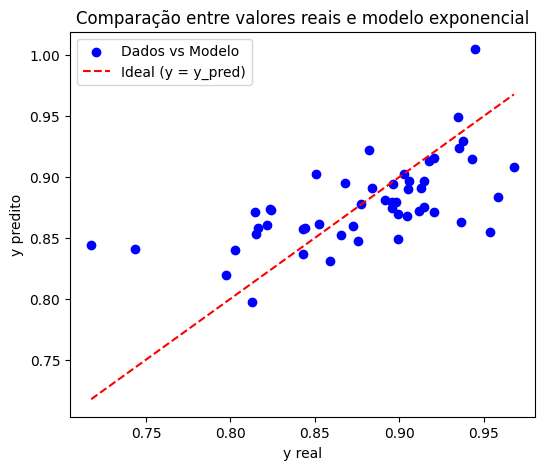

=== Resultado do modelo ===
Variáveis selecionadas: ['P ppm', 'Na ppm', 'C ppm', 'Mn ppm']
Equação: y = 8.075e-01 * exp( + 6.46e-05*(P ppm) + 6.38e-06*(Na ppm) - 3.50e-05*(C ppm) + 4.45e-06*(Mn ppm) )
YEO = None | scaler = None
R² = 0.3799 | R² ajustado = 0.3260
Erro padrão do R² ajustado = 0.0865
AIC = -313.56 | BIC = -303.90 | RMSE = 0.042


In [23]:
model1E = exp_model(X,y,0)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model1E["variaveis"])
print("Equação:", model1E["equacao"])

print(f"YEO = {model1E['yeo_transformer']} | scaler = {model1E['scaler']}")
print(f"R² = {model1E['r2']:.4f} | R² ajustado = {model1E['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model1E['r2_adj_se']:.4f}")
print(f"AIC = {model1E['aic']:.2f} | BIC = {model1E['bic']:.2f} | RMSE = {model1E['rmse']:.3f}")

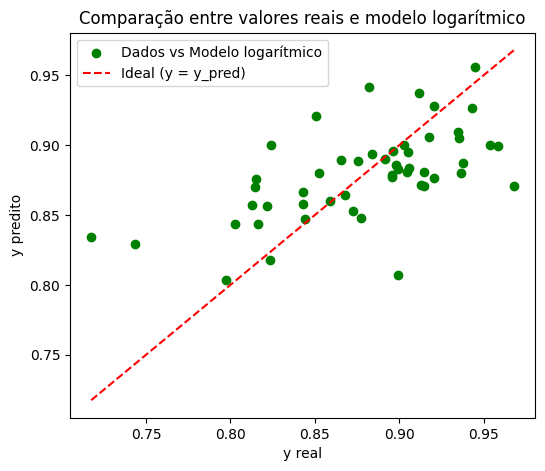

=== Resultado do modelo ===
Variáveis selecionadas: ['U ppm', 'Fe ppm', 'P ppm', 'Th ppm']
Equação: y = 1.401e+00 + 2.91e-02*ln(U ppm) - 6.45e-02*ln(Fe ppm) + 3.51e-02*ln(P ppm) - 2.46e-02*ln(Th ppm)
R² = 0.3574 | R² ajustado = 0.3015
Erro padrão do R² ajustado = 0.1103
AIC = -311.74 | BIC = -302.08 | RMSE = 0.043


In [24]:
model1L = log_model(X,y,0)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model1L["variaveis"])
print("Equação:", model1L["equacao"])
print(f"R² = {model1L['r2']:.4f} | R² ajustado = {model1L['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model1L['r2_adj_se']:.4f}")
print(f"AIC = {model1L['aic']:.2f} | BIC = {model1L['bic']:.2f} | RMSE = {model1L['rmse']:.3f}")

###[1.2]REGRESSÃO COM DADOS PADRONIZADOS

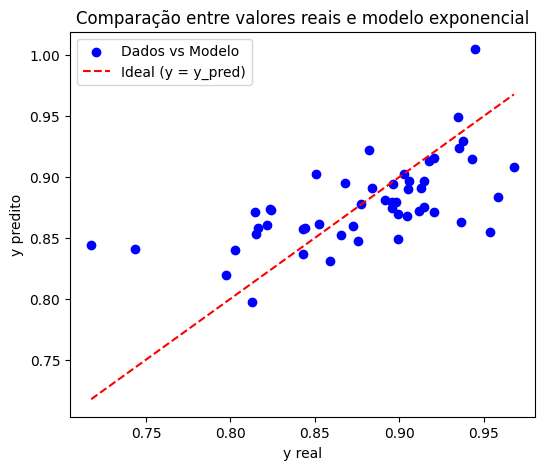

=== Resultado do modelo ===
Variáveis selecionadas: ['P ppm', 'Na ppm', 'C ppm', 'Mn ppm']
Equação: y = 8.772e-01 * exp( + 2.93e-02*(P ppm) + 4.10e-02*(Na ppm) - 1.78e-02*(C ppm) + 1.50e-02*(Mn ppm) )
YEO = None | scaler = StandardScaler()
R² = 0.3799 | R² ajustado = 0.3260
Erro padrão do R² ajustado = 0.0846
AIC = -313.56 | BIC = -303.90 | RMSE = 0.042


In [25]:
model2E = exp_model(X,y,1)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model2E["variaveis"])
print("Equação:", model2E["equacao"])

print(f"YEO = {model2E['yeo_transformer']} | scaler = {model2E['scaler']}")
print(f"R² = {model2E['r2']:.4f} | R² ajustado = {model2E['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model2E['r2_adj_se']:.4f}")
print(f"AIC = {model2E['aic']:.2f} | BIC = {model2E['bic']:.2f} | RMSE = {model2E['rmse']:.3f}")

Aviso: 558 valores negativos detectados — convertendo para positivos.


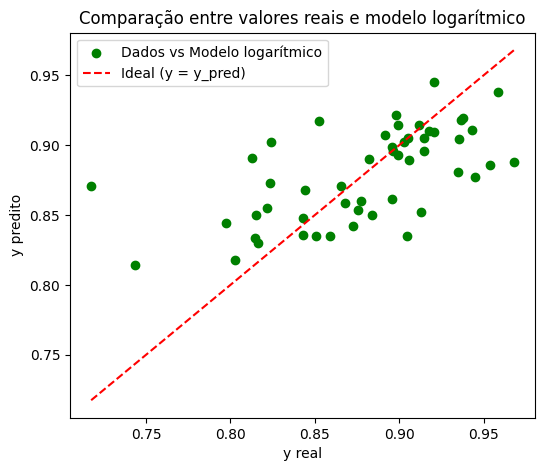

=== Resultado do modelo ===
Variáveis selecionadas: ['Mn ppm', 'Au ppm', 'Mg ppm', 'Ti ppm']
Equação: y = 9.041e-01 + 2.98e-02*ln(Mn ppm) + 2.23e-02*ln(Au ppm) - 1.45e-02*ln(Mg ppm) + 9.06e-03*ln(Ti ppm)
R² = 0.3726 | R² ajustado = 0.3180
Erro padrão do R² ajustado = 0.1166
AIC = -312.96 | BIC = -303.30 | RMSE = 0.042


In [26]:
model2L = log_model(X,y,1)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model2L["variaveis"])
print("Equação:", model2L["equacao"])
print(f"R² = {model2L['r2']:.4f} | R² ajustado = {model2L['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model2L['r2_adj_se']:.4f}")
print(f"AIC = {model2L['aic']:.2f} | BIC = {model2L['bic']:.2f} | RMSE = {model2L['rmse']:.3f}")

###[1.3]REGRESSÃO COM DADOS NORMALIZADOS

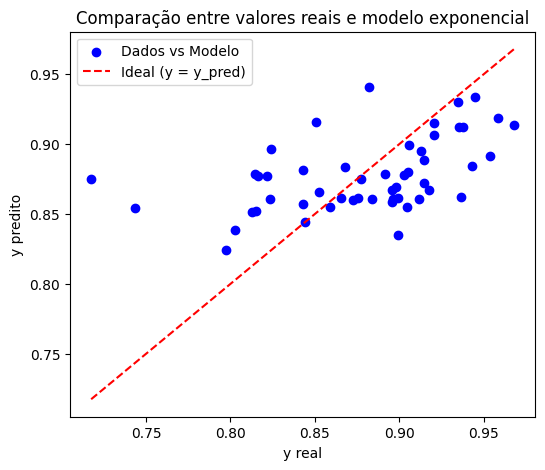

=== Resultado do modelo ===
Variáveis selecionadas: ['P ppm', 'Na ppm']
Equação: y = 8.772e-01 * exp( + 2.55e-02*(P ppm) + 2.02e-02*(Na ppm) )
YEO = PowerTransformer() | scaler = StandardScaler()
R² = 0.2334 | R² ajustado = 0.2015
Erro padrão do R² ajustado = 0.1015
AIC = -306.74 | BIC = -300.95 | RMSE = 0.047


In [27]:
model3E = exp_model(X,y,2)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model3E["variaveis"])
print("Equação:", model3E["equacao"])

print(f"YEO = {model3E['yeo_transformer']} | scaler = {model3E['scaler']}")
print(f"R² = {model3E['r2']:.4f} | R² ajustado = {model3E['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model3E['r2_adj_se']:.4f}")
print(f"AIC = {model3E['aic']:.2f} | BIC = {model3E['bic']:.2f} | RMSE = {model3E['rmse']:.3f}")

Aviso: 468 valores negativos detectados — convertendo para positivos.


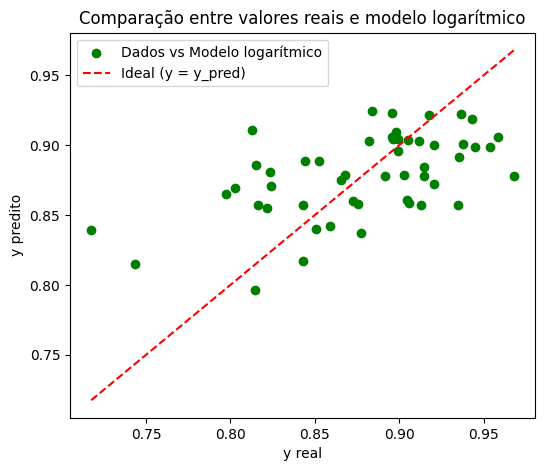

=== Resultado do modelo ===
Variáveis selecionadas: ['Mn ppm', 'Na ppm', 'Ag ppm', 'Ca ppm']
Equação: y = 8.963e-01 + 1.85e-02*ln(Mn ppm) + 1.55e-02*ln(Na ppm) + 1.66e-02*ln(Ag ppm) - 1.51e-02*ln(Ca ppm)
R² = 0.3000 | R² ajustado = 0.2391
Erro padrão do R² ajustado = 0.1027
AIC = -307.37 | BIC = -297.71 | RMSE = 0.045


In [28]:
model3L = log_model(X,y,2)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model3L["variaveis"])
print("Equação:", model3L["equacao"])
print(f"R² = {model3L['r2']:.4f} | R² ajustado = {model3L['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model3L['r2_adj_se']:.4f}")
print(f"AIC = {model3L['aic']:.2f} | BIC = {model3L['bic']:.2f} | RMSE = {model3L['rmse']:.3f}")

## [2]  REGRESSÃO COM VARIÁVEIS ORIGINAIS + TRANSFORMADAS

In [29]:
df_temp_flotation_sonov = df_temp_flotation_sonov.loc[y.index]

In [30]:
df_temp_flotation_sonov = df_temp_flotation_sonov.replace([np.inf, -np.inf], np.nan).dropna()
y2 = y.loc[df_temp_flotation_sonov.index]

###[2.1] REGRESSÃO COM DADOS ORIGINAIS

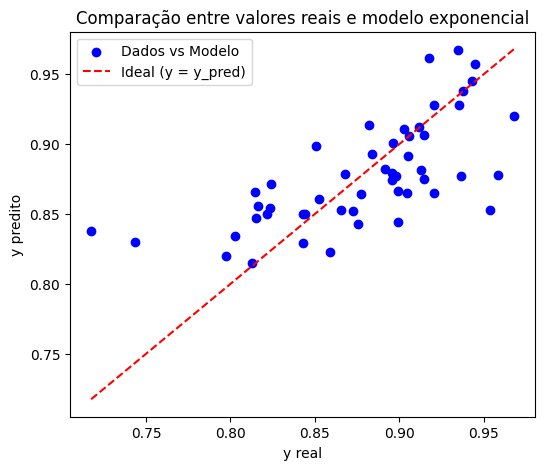

=== Resultado do modelo ===
Variáveis selecionadas: ['P ppm', '(Na ppm/Mn ppm)', '(Na ppm+Mn ppm)', '(P ppm*C ppm)']
Equação: y = 7.756e-01 * exp( + 1.03e-04*(P ppm) + 2.16e-03*((Na ppm/Mn ppm)) + 5.12e-06*((Na ppm+Mn ppm)) - 4.00e-08*((P ppm*C ppm)) )
YEO = None | scaler = None
R² = 0.4579 | R² ajustado = 0.4107
Erro padrão do R² ajustado = 0.0854
AIC = -320.41 | BIC = -310.75 | RMSE = 0.039


In [31]:
model4E = exp_model(df_temp_flotation_sonov,y2,0)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model4E["variaveis"])
print("Equação:", model4E["equacao"])

print(f"YEO = {model4E['yeo_transformer']} | scaler = {model4E['scaler']}")
print(f"R² = {model4E['r2']:.4f} | R² ajustado = {model4E['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model4E['r2_adj_se']:.4f}")
print(f"AIC = {model4E['aic']:.2f} | BIC = {model4E['bic']:.2f} | RMSE = {model4E['rmse']:.3f}")

Aviso: 306 valores negativos detectados — convertendo para positivos.


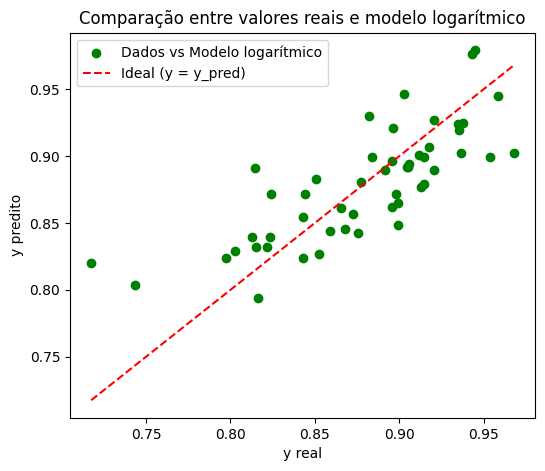

=== Resultado do modelo ===
Variáveis selecionadas: ['(P ppm*Na ppm)', '(C ppm - P ppm)', '(Mn ppm - Na ppm)', '(P ppm/C ppm)', '(C ppm - Mn ppm)', '(C ppm+Mn ppm)', '(Na ppm - P ppm)', 'F ppm', '(Log(Mn ppm))']
Equação: y = 9.504e-01 - 6.21e-03*ln((P ppm*Na ppm)) + 1.35e-02*ln((C ppm - P ppm)) + 5.56e-03*ln((Mn ppm - Na ppm)) + 3.89e-02*ln((P ppm/C ppm)) - 3.65e-02*ln((C ppm - Mn ppm)) + 1.56e-01*ln((C ppm+Mn ppm)) + 1.25e-02*ln((Na ppm - P ppm)) - 1.86e-02*ln(F ppm) - 5.23e-01*ln((Log(Mn ppm)))
R² = 0.6041 | R² ajustado = 0.5172
Erro padrão do R² ajustado = 0.0732
AIC = -326.44 | BIC = -307.12 | RMSE = 0.033


In [32]:
model4L = log_model(df_temp_flotation_sonov,y2,0)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model4L["variaveis"])
print("Equação:", model4L["equacao"])
print(f"R² = {model4L['r2']:.4f} | R² ajustado = {model4L['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model4L['r2_adj_se']:.4f}")
print(f"AIC = {model4L['aic']:.2f} | BIC = {model4L['bic']:.2f} | RMSE = {model4L['rmse']:.3f}")

###[2.2] REGRESSÃO COM DADOS PADRONIZADOS

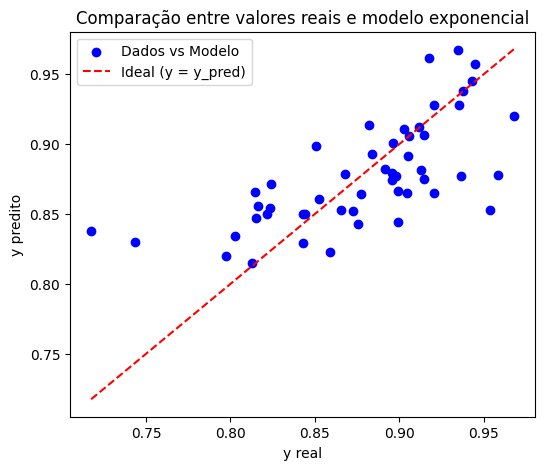

=== Resultado do modelo ===
Variáveis selecionadas: ['P ppm', '(Na ppm/Mn ppm)', '(Na ppm+Mn ppm)', '(P ppm*C ppm)']
Equação: y = 8.772e-01 * exp( + 4.67e-02*(P ppm) + 1.89e-02*((Na ppm/Mn ppm)) + 2.78e-02*((Na ppm+Mn ppm)) - 2.45e-02*((P ppm*C ppm)) )
YEO = None | scaler = StandardScaler()
R² = 0.4579 | R² ajustado = 0.4107
Erro padrão do R² ajustado = 0.0881
AIC = -320.41 | BIC = -310.75 | RMSE = 0.039


In [33]:
model5E = exp_model(df_temp_flotation_sonov,y2,1)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model5E["variaveis"])
print("Equação:", model5E["equacao"])

print(f"YEO = {model5E['yeo_transformer']} | scaler = {model5E['scaler']}")
print(f"R² = {model5E['r2']:.4f} | R² ajustado = {model5E['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model5E['r2_adj_se']:.4f}")
print(f"AIC = {model5E['aic']:.2f} | BIC = {model5E['bic']:.2f} | RMSE = {model5E['rmse']:.3f}")

Aviso: 1943 valores negativos detectados — convertendo para positivos.


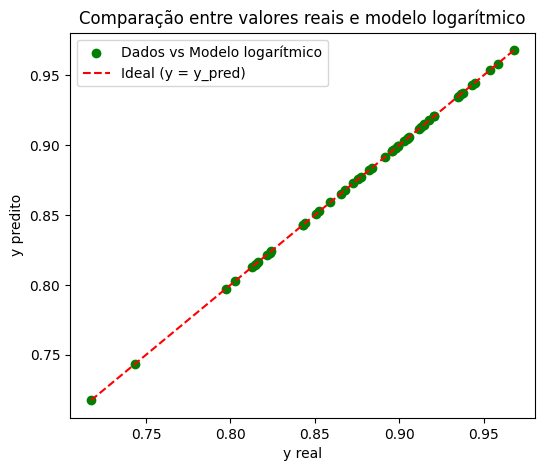

=== Resultado do modelo ===
Variáveis selecionadas: ['(C ppm/Mn ppm)', '(C ppm - Mn ppm)', 'Au ppm', '(Na ppm/C ppm)', '(C ppm - Na ppm)', 'Mg ppm', 'Si ppm', '(C ppm/Na ppm)', 'Ag ppm', 'Na ppm', '(Log(Na ppm))', '(P ppm+Na ppm)', '(Na ppm - P ppm)', '(C ppm*Mn ppm)', 'C ppm', '(Na ppm+Mn ppm)', '(C ppm - P ppm)', '(C ppm+Mn ppm)', 'U ppm', 'Al ppm', '(Mn ppm/C ppm)', '(Na ppm/Mn ppm)', '(Na ppm^2)', '(Log(P ppm))', '(Na ppm+C ppm)', 'Th ppm', 'Fe ppm', 'Ca ppm', '(Na ppm/P ppm)', 'Ti ppm', '(P ppm/C ppm)', '(P ppm/Na ppm)', '(Log(Mn ppm))', 'F ppm', 'Mn ppm', '(Mn ppm/Na ppm)', '(Log(C ppm))', '(P ppm/Mn ppm)', '(P ppm+Mn ppm)', '(P ppm*C ppm)', '(Mn ppm/P ppm)', '(P ppm*Na ppm)', 'P ppm', '(P ppm^2)', 'S ppm', 'K ppm', '(Mn ppm^2)', '(C ppm^2)', '(P ppm+C ppm)', '(Na ppm*C ppm)', '(Na ppm*Mn ppm)']
Equação: y = 7.971e-01 + 6.55e-02*ln((C ppm/Mn ppm)) - 1.14e-01*ln((C ppm - Mn ppm)) + 1.10e-02*ln(Au ppm) + 9.60e-03*ln((Na ppm/C ppm)) - 7.40e-01*ln((C ppm - Na ppm)) - 1.36e-02*ln(Mg p

In [34]:
model5L = log_model(df_temp_flotation_sonov,y2,1)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model5L["variaveis"])
print("Equação:", model5L["equacao"])
print(f"R² = {model5L['r2']:.4f} | R² ajustado = {model5L['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model5L['r2_adj_se']:.4f}")
print(f"AIC = {model5L['aic']:.2f} | BIC = {model5L['bic']:.2f} | RMSE = {model5L['rmse']:.3f}")

###[2.3] REGRESSÃO COM DADOS NORMALIZADOS

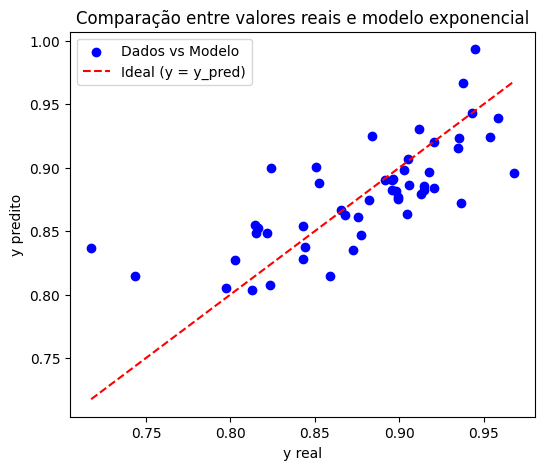

=== Resultado do modelo ===
Variáveis selecionadas: ['(P ppm/Mn ppm)', '(P ppm - Mn ppm)', '(C ppm - Na ppm)', 'Th ppm']
Equação: y = 8.772e-01 * exp( + 8.00e-02*((P ppm/Mn ppm)) - 7.10e-02*((P ppm - Mn ppm)) - 2.74e-02*((C ppm - Na ppm)) - 1.05e-02*(Th ppm) )
YEO = PowerTransformer() | scaler = StandardScaler()
R² = 0.5543 | R² ajustado = 0.5155
Erro padrão do R² ajustado = 0.0753
AIC = -330.39 | BIC = -320.74 | RMSE = 0.036


In [35]:
model6E = exp_model(df_temp_flotation_sonov,y2,2)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model6E["variaveis"])
print("Equação:", model6E["equacao"])

print(f"YEO = {model6E['yeo_transformer']} | scaler = {model6E['scaler']}")
print(f"R² = {model6E['r2']:.4f} | R² ajustado = {model6E['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model6E['r2_adj_se']:.4f}")
print(f"AIC = {model6E['aic']:.2f} | BIC = {model6E['bic']:.2f} | RMSE = {model6E['rmse']:.3f}")

Aviso: 1627 valores negativos detectados — convertendo para positivos.


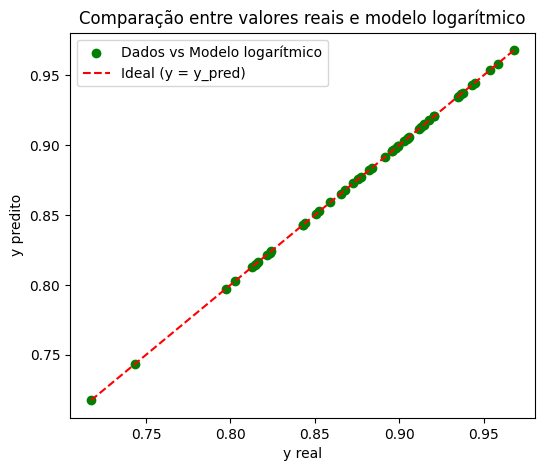

=== Resultado do modelo ===
Variáveis selecionadas: ['(C ppm/Mn ppm)', '(Na ppm/P ppm)', '(Na ppm/Mn ppm)', '(C ppm - Na ppm)', '(Mn ppm - P ppm)', '(P ppm - C ppm)', 'Ag ppm', 'Si ppm', '(P ppm/Mn ppm)', '(Mn ppm/P ppm)', 'S ppm', 'F ppm', '(P ppm/C ppm)', 'Al ppm', '(Na ppm*C ppm)', 'K ppm', '(P ppm*Na ppm)', 'U ppm', 'C ppm', '(Log(C ppm))', '(P ppm/Na ppm)', 'P ppm', 'Mg ppm', '(Na ppm/C ppm)', '(C ppm - P ppm)', 'Fe ppm', '(C ppm+Mn ppm)', '(C ppm^2)', '(Mn ppm/C ppm)', '(P ppm^2)', '(P ppm+Na ppm)', '(C ppm/Na ppm)', '(C ppm*Mn ppm)', '(P ppm*C ppm)', '(P ppm - Mn ppm)', '(Na ppm*Mn ppm)', '(P ppm - Na ppm)', '(Na ppm+Mn ppm)', 'Au ppm', '(Log(Mn ppm))', 'Ca ppm', '(C ppm/P ppm)', '(Na ppm - P ppm)', '(Mn ppm - C ppm)', '(Mn ppm/Na ppm)', 'Th ppm', '(P ppm*Mn ppm)', '(Log(P ppm))', '(Na ppm - C ppm)', '(Na ppm - Mn ppm)', '(P ppm+Mn ppm)', '(Log(Na ppm))', '(Mn ppm^2)', '(Na ppm^2)', '(P ppm+C ppm)', 'Cu ppm', 'Ti ppm', '(Na ppm+C ppm)', '(Mn ppm - Na ppm)', 'Na ppm']
Equação: y 

In [36]:
model6L = log_model(df_temp_flotation_sonov,y2,2)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model6L["variaveis"])
print("Equação:", model6L["equacao"])
print(f"R² = {model6L['r2']:.4f} | R² ajustado = {model6L['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model6L['r2_adj_se']:.4f}")
print(f"AIC = {model6L['aic']:.2f} | BIC = {model6L['bic']:.2f} | RMSE = {model6L['rmse']:.3f}")

##[3] REGRESSÃO COM VARIÁVEIS ORIGINAIS + TRANSFORMADAS + ESPECIAIS

In [37]:
df_temp_flotation = df_temp_flotation.loc[y.index]

In [38]:
df_temp_flotation = df_temp_flotation.replace([np.inf, -np.inf], np.nan).dropna()
y3 = y.loc[df_temp_flotation.index]


###[3.1]REGRESSÃO COM DADOS ORiGINAIS

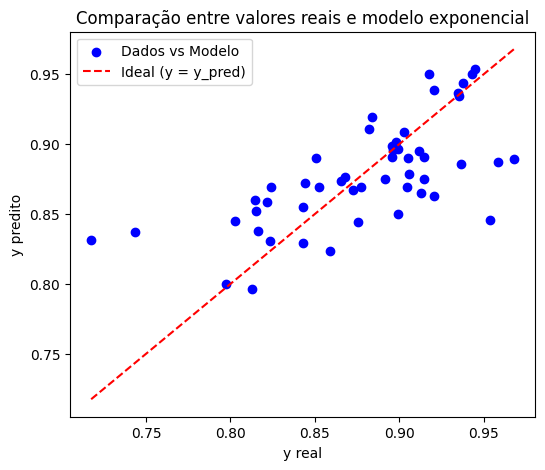

=== Resultado do modelo ===
Variáveis selecionadas: ['Fe+Ca/S_ratio', '(Na ppm+Mn ppm)', '(C ppm - P ppm)', '(Na ppm*Mn ppm)', 'Ag/Cu_ratio', 'U ppm']
Equação: y = 8.141e-01 * exp( - 2.27e-04*(Fe+Ca/S_ratio) + 9.06e-06*((Na ppm+Mn ppm)) - 4.69e-05*((C ppm - P ppm)) - 1.35e-09*((Na ppm*Mn ppm)) - 4.94e-05*(Ag/Cu_ratio) + 5.18e-04*(U ppm) )
YEO = None | scaler = None
R² = 0.4562 | R² ajustado = 0.3820
Erro padrão do R² ajustado = 0.0960
AIC = -316.25 | BIC = -302.73 | RMSE = 0.039


In [39]:
model7E = exp_model(df_temp_flotation,y3,0)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model7E["variaveis"])
print("Equação:", model7E["equacao"])
print(f"YEO = {model7E['yeo_transformer']} | scaler = {model7E['scaler']}")
print(f"R² = {model7E['r2']:.4f} | R² ajustado = {model7E['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model7E['r2_adj_se']:.4f}")
print(f"AIC = {model7E['aic']:.2f} | BIC = {model7E['bic']:.2f} | RMSE = {model7E['rmse']:.3f}")

Aviso: 306 valores negativos detectados — convertendo para positivos.


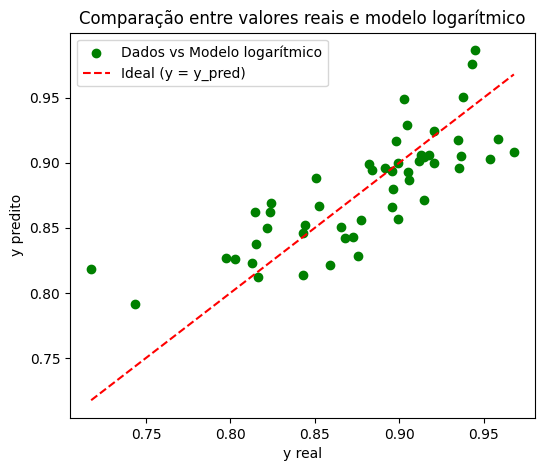

=== Resultado do modelo ===
Variáveis selecionadas: ['S/Fe_ratio', '(C ppm - P ppm)', '(P ppm+Na ppm)', '(Na ppm+C ppm)', '(Mn ppm - Na ppm)', 'Th ppm', '(C ppm - Mn ppm)', '(Na ppm+Mn ppm)', '(P ppm*Na ppm)', 'K/Al_ratio', '(C ppm - Na ppm)']
Equação: y = 4.713e-01 + 3.96e-03*ln(S/Fe_ratio) + 1.83e-02*ln((C ppm - P ppm)) + 4.09e-02*ln((P ppm+Na ppm)) - 6.17e-02*ln((Na ppm+C ppm)) - 1.48e-02*ln((Mn ppm - Na ppm)) - 1.93e-02*ln(Th ppm) - 2.79e-02*ln((C ppm - Mn ppm)) + 7.83e-02*ln((Na ppm+Mn ppm)) + 1.84e-02*ln((P ppm*Na ppm)) + 2.55e-02*ln(K/Al_ratio) - 1.02e-02*ln((C ppm - Na ppm))
R² = 0.6348 | R² ajustado = 0.5317
Erro padrão do R² ajustado = 0.0674
AIC = -326.55 | BIC = -303.37 | RMSE = 0.032


In [40]:
model7L = log_model(df_temp_flotation,y3,0)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model7L["variaveis"])
print("Equação:", model7L["equacao"])
print(f"R² = {model7L['r2']:.4f} | R² ajustado = {model7L['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model7L['r2_adj_se']:.4f}")
print(f"AIC = {model7L['aic']:.2f} | BIC = {model7L['bic']:.2f} | RMSE = {model7L['rmse']:.3f}")

###[3.2]REGRESSÃO COM DADOS PADRONIZADOS

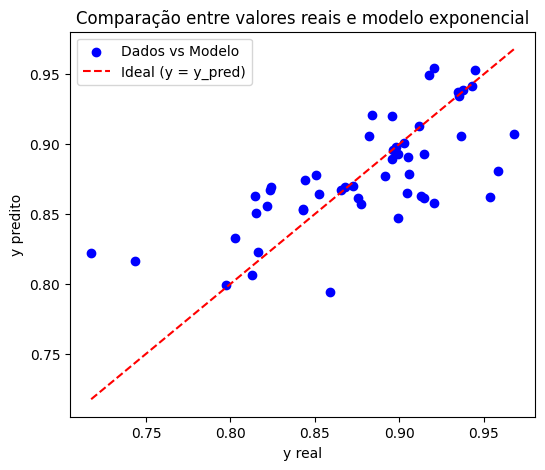

=== Resultado do modelo ===
Variáveis selecionadas: ['Fe+Ca/S_ratio', '(Na ppm+Mn ppm)', '(C ppm - P ppm)', '(Na ppm*Mn ppm)', 'Ag/Cu_ratio', 'U ppm']
Equação: y = 8.772e-01 * exp( - 2.81e-02*(Fe+Ca/S_ratio) + 4.87e-02*((Na ppm+Mn ppm)) - 3.13e-02*((C ppm - P ppm)) - 2.17e-02*((Na ppm*Mn ppm)) + 2.53e-02*(Ag/Cu_ratio) + 1.53e-02*(U ppm) )
YEO = None | scaler = StandardScaler()
R² = 0.5031 | R² ajustado = 0.4353
Erro padrão do R² ajustado = 0.1014
AIC = -320.85 | BIC = -307.33 | RMSE = 0.038


In [41]:
model8E = exp_model(df_temp_flotation,y3,1)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model8E["variaveis"])
print("Equação:", model8E["equacao"])
print(f"YEO = {model8E['yeo_transformer']} | scaler = {model8E['scaler']}")
print(f"R² = {model8E['r2']:.4f} | R² ajustado = {model8E['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model8E['r2_adj_se']:.4f}")
print(f"AIC = {model8E['aic']:.2f} | BIC = {model8E['bic']:.2f} | RMSE = {model8E['rmse']:.3f}")

Aviso: 2250 valores negativos detectados — convertendo para positivos.


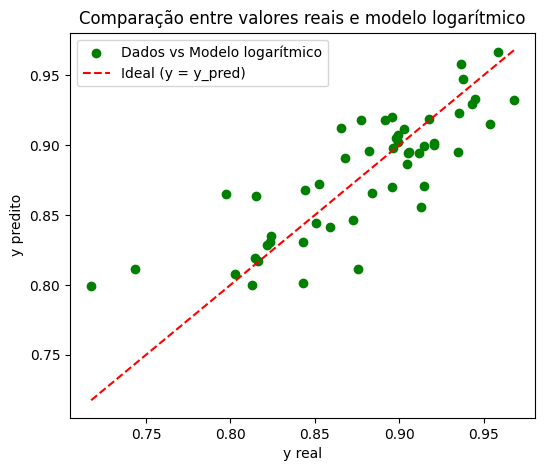

=== Resultado do modelo ===
Variáveis selecionadas: ['(C ppm/Mn ppm)', 'Au/Cu_ratio', '(C ppm - Mn ppm)', '(Na ppm/C ppm)', 'S/Fe_ratio', '(C ppm - P ppm)', '(Na ppm/P ppm)', '(Mn ppm/P ppm)', '(C ppm/P ppm)', '(P ppm*Mn ppm)']
Equação: y = 9.306e-01 + 4.60e-02*ln((C ppm/Mn ppm)) + 1.89e-02*ln(Au/Cu_ratio) + 3.11e-02*ln((C ppm - Mn ppm)) + 1.50e-02*ln((Na ppm/C ppm)) - 1.24e-02*ln(S/Fe_ratio) + 1.27e-02*ln((C ppm - P ppm)) - 1.19e-02*ln((Na ppm/P ppm)) - 1.03e-02*ln((Mn ppm/P ppm)) + 6.15e-03*ln((C ppm/P ppm)) - 8.46e-03*ln((P ppm*Mn ppm))
R² = 0.6812 | R² ajustado = 0.6015
Erro padrão do R² ajustado = 0.0702
AIC = -335.50 | BIC = -314.25 | RMSE = 0.030


In [42]:
model8L = log_model(df_temp_flotation,y3,1)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model8L["variaveis"])
print("Equação:", model8L["equacao"])
print(f"R² = {model8L['r2']:.4f} | R² ajustado = {model8L['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model8L['r2_adj_se']:.4f}")
print(f"AIC = {model8L['aic']:.2f} | BIC = {model8L['bic']:.2f} | RMSE = {model8L['rmse']:.3f}")

###[3.3] REGRESSÃO COM DADOS NORMALIZADOS

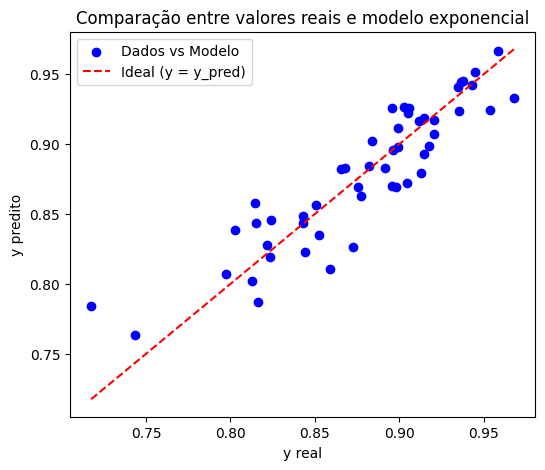

=== Resultado do modelo ===
Variáveis selecionadas: ['S/Fe_ratio', '(C ppm - P ppm)', '(Na ppm+Mn ppm)', '(P ppm/Mn ppm)', '(Na ppm - P ppm)', '(Mn ppm/P ppm)', 'U ppm', 'Ag/Cu_ratio', 'Ca/Mg_ratio', 'K/Al_ratio', '(C ppm/Mn ppm)', 'Na ppm', '(P ppm/C ppm)', 'Th ppm', '(Mn ppm/C ppm)', 'F ppm', '(Na ppm - C ppm)', '(Mn ppm^2)', '(Na ppm/Mn ppm)']
Equação: y = 8.772e-01 * exp( + 4.20e-03*(S/Fe_ratio) - 1.05e-02*((C ppm - P ppm)) + 7.72e-02*((Na ppm+Mn ppm)) + 2.51e-01*((P ppm/Mn ppm)) - 4.78e-02*((Na ppm - P ppm)) + 5.88e-02*((Mn ppm/P ppm)) + 4.80e-02*(U ppm) + 2.83e-02*(Ag/Cu_ratio) - 1.82e-02*(Ca/Mg_ratio) + 1.30e-02*(K/Al_ratio) - 1.47e-01*((C ppm/Mn ppm)) + 4.08e-02*(Na ppm) - 1.36e-01*((P ppm/C ppm)) - 2.17e-02*(Th ppm) + 5.75e-02*((Mn ppm/C ppm)) - 1.48e-02*(F ppm) - 3.13e-02*((Na ppm - C ppm)) - 5.70e-02*((Mn ppm^2)) - 4.01e-02*((Na ppm/Mn ppm)) )
YEO = PowerTransformer() | scaler = StandardScaler()
R² = 0.8173 | R² ajustado = 0.7053
Erro padrão do R² ajustado = 0.0610
AIC = -34

In [43]:
model9E = exp_model(df_temp_flotation,y3,2)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model9E["variaveis"])
print("Equação:", model9E["equacao"])
print(f"YEO = {model9E['yeo_transformer']} | scaler = {model9E['scaler']}")
print(f"R² = {model9E['r2']:.4f} | R² ajustado = {model9E['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model9E['r2_adj_se']:.4f}")
print(f"AIC = {model9E['aic']:.2f} | BIC = {model9E['bic']:.2f} | RMSE = {model9E['rmse']:.3f}")

Aviso: 1893 valores negativos detectados — convertendo para positivos.


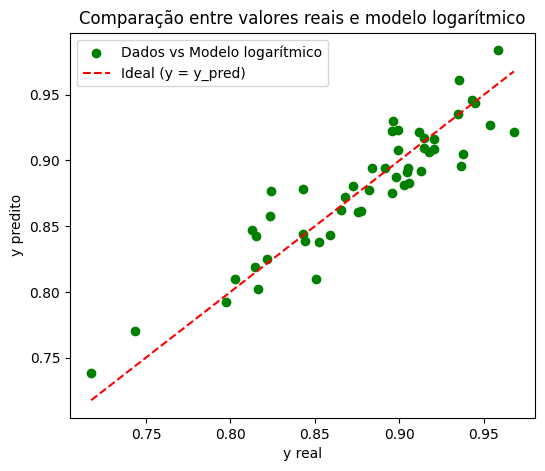

=== Resultado do modelo ===
Variáveis selecionadas: ['(C ppm/Mn ppm)', '(Na ppm/P ppm)', 'Ag/Cu_ratio', '(C ppm - Na ppm)', '(Na ppm/Mn ppm)', '(P ppm - C ppm)', '(P ppm/C ppm)', 'Mg ppm', 'Ag ppm', '(P ppm*C ppm)', 'Au/Cu_ratio', 'Al ppm', 'Na/Al_ratio', 'K ppm', '(P ppm*Na ppm)', '(C ppm/P ppm)', 'Fe+Ca/S_ratio']
Equação: y = 9.000e-01 + 1.03e-02*ln((C ppm/Mn ppm)) + 3.94e-02*ln((Na ppm/P ppm)) + 2.86e-02*ln(Ag/Cu_ratio) - 6.00e-02*ln((C ppm - Na ppm)) + 1.51e-02*ln((Na ppm/Mn ppm)) + 1.56e-02*ln((P ppm - C ppm)) - 6.54e-02*ln((P ppm/C ppm)) - 9.79e-03*ln(Mg ppm) + 2.24e-02*ln(Ag ppm) + 1.02e-02*ln((P ppm*C ppm)) + 1.54e-02*ln(Au/Cu_ratio) - 9.12e-03*ln(Al ppm) + 3.11e-02*ln(Na/Al_ratio) - 1.01e-02*ln(K ppm) + 1.27e-02*ln((P ppm*Na ppm)) + 6.47e-02*ln((C ppm/P ppm)) - 7.49e-03*ln(Fe+Ca/S_ratio)
R² = 0.8379 | R² ajustado = 0.7544
Erro padrão do R² ajustado = 0.0554
AIC = -355.99 | BIC = -321.21 | RMSE = 0.021


In [44]:
model9L = log_model(df_temp_flotation,y3,2)
print("=== Resultado do modelo ===")
print("Variáveis selecionadas:", model9L["variaveis"])
print("Equação:", model9L["equacao"])
print(f"R² = {model9L['r2']:.4f} | R² ajustado = {model9L['r2_ajustado']:.4f}")
print(f"Erro padrão do R² ajustado = {model9L['r2_adj_se']:.4f}")
print(f"AIC = {model9L['aic']:.2f} | BIC = {model9L['bic']:.2f} | RMSE = {model9L['rmse']:.3f}")

***
# <font size = 12 color = RED> REFERÊNCIAS BIBLIOGRÁFRICAS </font>
***

ANDRADE, Rayssa Victória de. Modelagem geometalúrgica do tamanho de produto da prensa de rolos de alta pressão de uma mina de ferro. 2024. Monografia (Trabalho de Conclusão de Curso) - Departamento de Engenharia de Minas, Universidade Federal de Minas Gerais, Belo Horizonte, 2024.



https://blog.deepsim.ca/stepwise-regression-package-python/

https://www.statology.org/exponential-regression-python/

https://www.statology.org/logarithmic-regression-python/

GeoMet dataset - https://zenodo.org/records/7051975

Ratios in Geometallurgy - https://www.youtube.com/watch?v=tfxkDFJY9lE

## SCRATCH LOGARITHMIC AND EXPONENCIAL REGRESSION

### logarithmic

In [45]:
xL = np.arange(1, 16, 1)
yL = np.array([59, 50, 44, 38, 33, 28, 23, 20, 17, 15, 13, 12, 11, 10, 9.5])

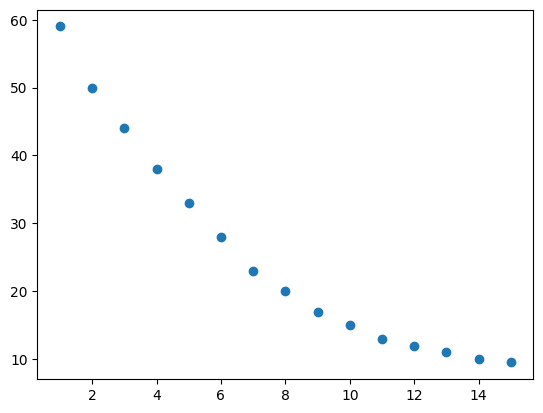

In [46]:
plt.scatter(xL, yL)
plt.show()

In [47]:
#fit the model
fit = np.polyfit(np.log(xL), yL, 1)

#view the output of the model
print(fit)

[-20.19869943  63.06859979]


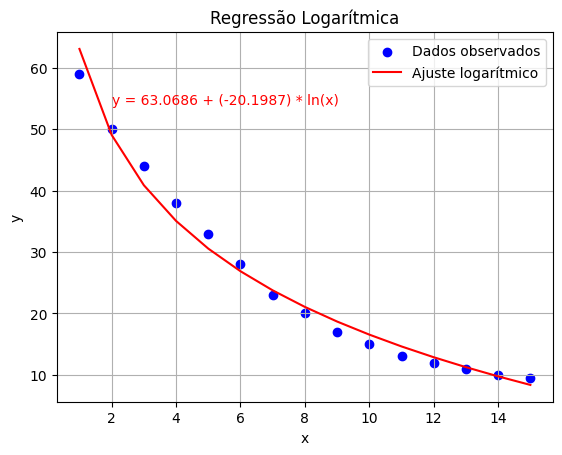

In [48]:
b, a = fit  # b é o coeficiente angular, a é o intercepto

# gerar valores preditos
y_pred = a + b * np.log(xL)

# plotar dados originais e curva ajustada
plt.scatter(xL, yL, color='blue', label='Dados observados')
plt.plot(xL, y_pred, color='red', label='Ajuste logarítmico')

# exibir equação no gráfico
equacao = f"y = {a:.4f} + ({b:.4f}) * ln(x)"
plt.text(2, max(yL)-5, equacao, fontsize=10, color='red')

# rótulos e legenda
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regressão Logarítmica')
plt.legend()
plt.grid(True)
plt.show()


###Exponetial

In [49]:

xx = np.arange(1, 21, 1)
yx = np.array([1, 3, 5, 7, 9, 12, 15, 19, 23, 28,
              33, 38, 44, 50, 56, 64, 73, 84, 97, 113])

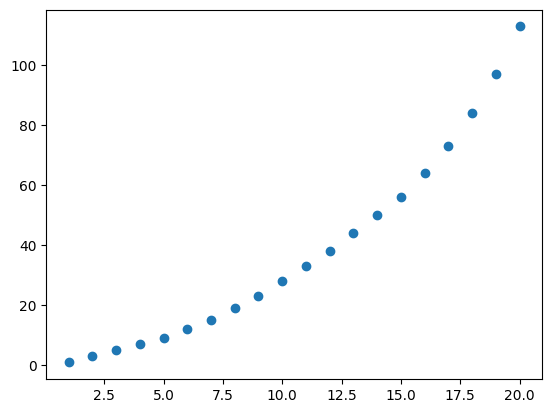

In [50]:

plt.scatter(xx, yx)
plt.show()

In [51]:
fit = np.polyfit(xx, np.log(yx), 1)

#view the output of the model
print(fit)



[0.2041002  0.98165772]


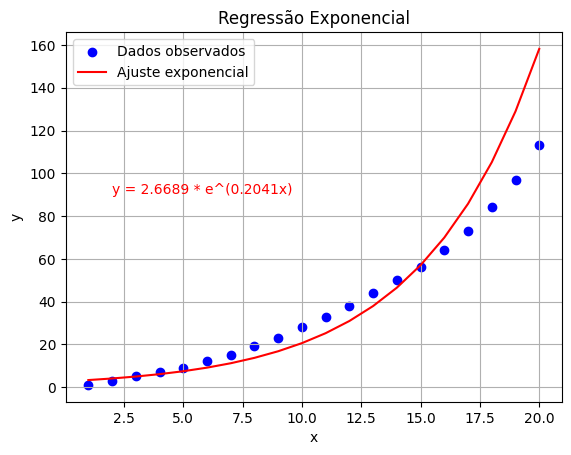

Coeficiente de determinação (R²): 0.8085
Equação: y = 2.6689 * e^(0.2041x)


In [52]:
b, ln_a = fit  # b = coeficiente angular, ln_a = ln(a)
a = np.exp(ln_a)

# gerar valores preditos
y_pred = a * np.exp(b * xx)

# plotar dados e curva ajustada
plt.scatter(xx, yx, color='blue', label='Dados observados')
plt.plot(xx, y_pred, color='red', label='Ajuste exponencial')

# exibir equação no gráfico
equacao = f"y = {a:.4f} * e^({b:.4f}x)"
plt.text(2, max(yx)*0.8, equacao, fontsize=10, color='red')

# rótulos e legenda
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regressão Exponencial')
plt.legend()
plt.grid(True)
plt.show()

# calcular R²
ss_res = np.sum((yx - y_pred) ** 2)
ss_tot = np.sum((yx - np.mean(yx)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"Coeficiente de determinação (R²): {r2:.4f}")
print(f"Equação: y = {a:.4f} * e^({b:.4f}x)")

Equação do modelo:
y = 2.867 * exp( + 0.782*X1 - 0.339*X2)

R² = 0.9975


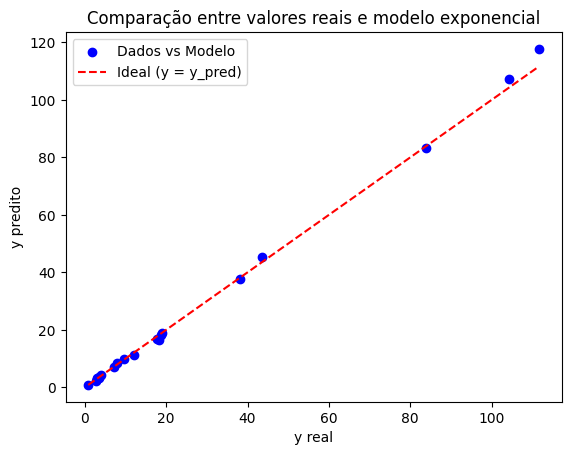

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# ==== Exemplo de dados ====
X = np.random.rand(20, 2) * 5
y = 2.5 * np.exp(0.8 * X[:, 0] - 0.3 * X[:, 1]) + np.random.normal(0, 0.5, 20)

# ==== Linearização ====
Y_log = np.log(y)
X_ones = np.column_stack((np.ones(X.shape[0]), X))

# ==== Ajuste linear ====
coef = np.linalg.lstsq(X_ones, Y_log, rcond=None)[0]
a_est = np.exp(coef[0])  # intercepto (exp do B0)
b_est = coef[1:]         # coeficientes das variáveis

# ==== Predição ====
y_pred = a_est * np.exp(X @ b_est)

# ==== R² ====
r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

# ==== Equação final ====
equacao = f"y = {a_est:.3f} * exp("
if b_est.ndim == 0:  # caso escalar
    equacao += f"{b_est:.3f}*X"
else:
    for i, b in enumerate(b_est):
        sinal = " + " if b >= 0 else " - "
        equacao += f"{sinal}{abs(b):.3f}*X{i+1}"
equacao += ")"

# ==== Exibição ====
print("Equação do modelo:")
print(equacao)
print(f"\nR² = {r2:.4f}")

# ==== Gráfico comparativo ====
plt.scatter(y, y_pred, color="blue", label="Dados vs Modelo")
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label="Ideal (y = y_pred)")
plt.xlabel("y real")
plt.ylabel("y predito")
plt.title("Comparação entre valores reais e modelo exponencial")
plt.legend()
plt.show()
